In [1]:
from dreams.api import dreams_embeddings
from dreams.utils.data import MSData

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
msdata = MSData.from_mzml('/Users/maxvandenboom/Docs/Coding/AI/active/data/hypermarker/formatted/batch01/2449SAB_0001_A1.mzML')

Loading dataset 2449SAB_0001_A1 into memory (11714 spectra)...


In [3]:
embs = dreams_embeddings('/Users/maxvandenboom/Docs/Coding/AI/active/data/hypermarker/formatted/batch01/0001_A1/2449SAB_0001_A1.hdf5')

Computing DreaMS embedding: 100%|██████████| 11714/11714 [04:42<00:00, 41.50it/s]


In [4]:
print(embs)

[[-1.4908372   0.41281658  0.51259863 ...  0.8040847  -0.36079675
   0.3764759 ]
 [ 0.42473233  0.34141263 -0.01164605 ... -1.3171542   0.43005353
   0.49836168]
 [ 0.2772416   0.30914724  0.4560889  ...  0.02909076 -0.47527027
   1.7312536 ]
 ...
 [ 0.2154498   0.46328554  0.5401947  ... -0.64660084 -0.69662535
   1.5063437 ]
 [ 0.2773544  -0.5896848  -0.06968109 ... -0.33883458  0.5279677
   0.04564004]
 [ 1.637624   -0.8923483   1.5037966  ... -1.5326122  -0.91144377
  -0.83506507]]


In [5]:
import numpy as np

# Assuming 'embeddings' is your NumPy array of embeddings
np.save('/Users/maxvandenboom/Docs/Coding/AI/active/data/hypermarker/embeddings/test.npy', embs)

In [8]:
msdata = MSData.load('/Users/maxvandenboom/Docs/Coding/AI/active/data/hypermarker/formatted/batch01/2449SAB_0001_A1.hdf5')
embs.shape

(11714, 1024)

In [4]:
import random
import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dreams.utils.data import MSData
from dreams.utils.plots import init_plotting
from dreams.utils.mols import formula_type
from dreams.definitions import DREAMS_EMBEDDING

/Users/maxvandenboom/anaconda3/envs/dreams/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


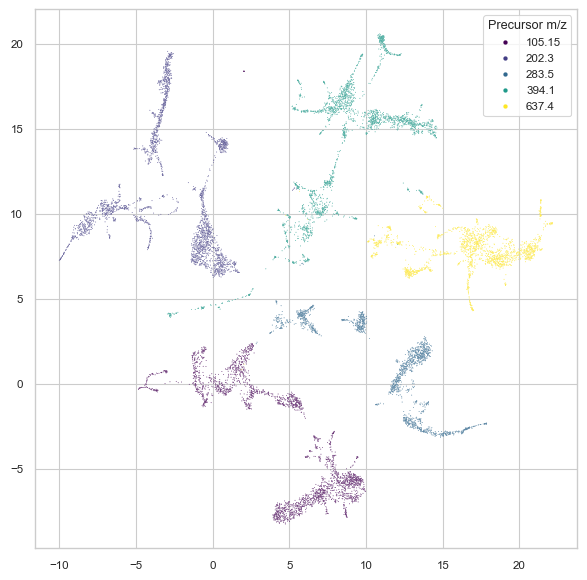

In [30]:
random.seed(777)
idx = random.sample(list(range(embs.shape[0])), 11714)
embs_sample = embs[idx]

reducer = umap.UMAP(metric='cosine', min_dist=0.4, n_neighbors=50)
embs_umap = reducer.fit_transform(embs_sample)
# init_plotting(figsize=(5, 5))
# formulas = np.array(msdata['FORMULA'])[idx]
# sns.scatterplot(
#     x=embs_umap[:, 0],
#     y=embs_umap[:, 1],
#     hue=[formula_type(f) for f in formulas],
#     alpha=1,
#     s=0.3,
#     palette=['#2664BF', '#34A89A', '#F69CA9', '#AD95D1', '#FBD399']
# )
# plt.legend(markerscale=5)
# plt.show()
init_plotting(figsize=(7, 7))
sns.scatterplot(
    x=embs_umap[:, 0],
    y=embs_umap[:, 1],
    hue=msdata.get_prec_mzs()[idx],
    alpha=1,
    s=0.4,
    palette='viridis'
)
plt.legend(title='Precursor m/z', markerscale=5)
plt.show()


Inspecting spectral data

In [ ]:
msdata.at(100)
spectra = msdata.get_spectra()

In [ ]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)
spectra[0]

LSH Clustering

In [13]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import dreams.utils.mols as mu
from dreams.utils.plots import init_plotting
from dreams.utils.spectra import PeakListModifiedCosine
from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
%reload_ext autoreload
%autoreload 2

In [17]:
in_pth = Path('/Users/maxvandenboom/Docs/Coding/AI/active/data/hypermarker/formatted/batch01/2449SAB_0001_A1.hdf5')
msdata = MSData.from_hdf5(in_pth)
msdata.get_spectra().shape

(11714, 2, 128)

In [18]:
lsh_projector = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)

In [19]:
lshs = lsh_projector.compute(msdata.get_spectra())
lshs.shape

Computing LSHs: 100%|██████████| 11714/11714 [00:02<00:00, 4927.51it/s]


(11714,)

In [21]:
np.unique(lshs).shape

(6425,)

In [22]:
pd.Series(lshs).value_counts()[:5]

/var/folders/ql/9dgs6k1j3d35q0rnf__xlhd00000gn/T/ipykernel_60596/3293225505.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  pd.Series(lshs).value_counts()[:5]


b'46b0af0e84f6b78518d8743cce962e9a2ea2d8826a6cc2f63ec7ab3c3217a9b2'    632
b'0f3963d33eb403434e415f3d3f9088d0ecac151d097cdf8daeae02d0fec18172'    291
b'3b1bf47bfb5886975c0e79c73c42f5c77eae79d626bec6f0b32f66a1669e343f'    132
b'45b18be88ff1be128d175f8039ae4b69b3c0549910a166c8381587ccc0011759'    102
b'09563793bc3bf2cc7ba86281529871b70cd8ae31c9f28115f91cfd8cd7f2ebb0'     96
Name: count, dtype: int64

/var/folders/ql/9dgs6k1j3d35q0rnf__xlhd00000gn/T/ipykernel_60596/1980347101.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  lsh_counts = pd.Series(lshs).value_counts()


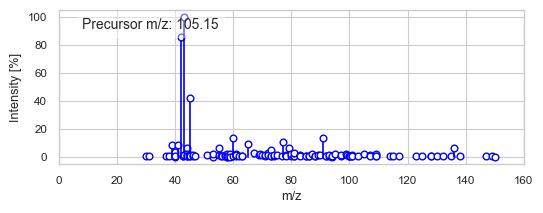

{'RT': 447.91999999997995, 'charge': 0, 'file_name': '2449SAB_0001_A1.mzML', 'precursor_mz': 105.15, 'scan_number': 8144}


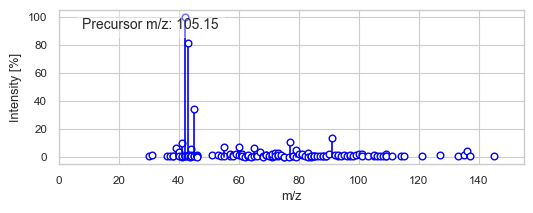

{'RT': 471.34900000002, 'charge': 0, 'file_name': '2449SAB_0001_A1.mzML', 'precursor_mz': 105.15, 'scan_number': 8570}


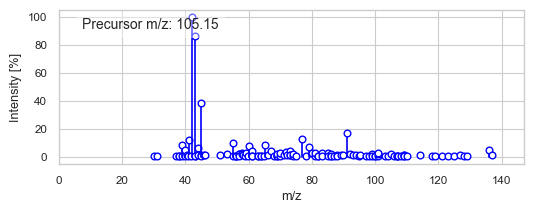

{'RT': 487.18699999998, 'charge': 0, 'file_name': '2449SAB_0001_A1.mzML', 'precursor_mz': 105.15, 'scan_number': 8858}


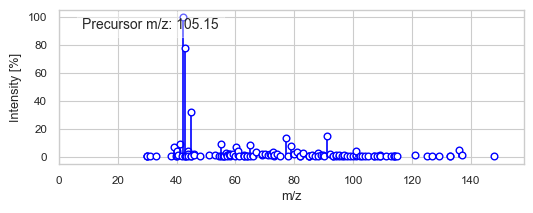

{'RT': 489.16799999999995, 'charge': 0, 'file_name': '2449SAB_0001_A1.mzML', 'precursor_mz': 105.15, 'scan_number': 8894}


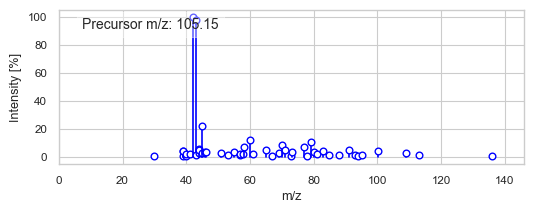

{'RT': 507.97600000002, 'charge': 0, 'file_name': '2449SAB_0001_A1.mzML', 'precursor_mz': 105.15, 'scan_number': 9236}


In [27]:
# Pick some LSH forming a cluster of 5 spectra
lsh_counts = pd.Series(lshs).value_counts()
lsh_i = lsh_counts[lsh_counts == 5].index[36]
idx = np.where(lshs == lsh_i)[0]

# Display clustered spectra
for i in idx:
    # Convert i to Python int explicitly to fix the issue
    i_int = int(i)
    print(msdata.at(i_int, plot_mol=True))

In [28]:
cos_sim = PeakListModifiedCosine()
cos_sim.compute_pairwise(specs=msdata['spectrum'][idx], prec_mzs=msdata['precursor_mz'][idx], avg=False)

array([[1.        , 0.98176364, 0.98596364, 0.97596147, 0.97252321],
       [0.98176364, 1.        , 0.99642028, 0.99652342, 0.97845166],
       [0.98596364, 0.99642028, 1.        , 0.9964696 , 0.97323448],
       [0.97596147, 0.99652342, 0.9964696 , 1.        , 0.97426938],
       [0.97252321, 0.97845166, 0.97323448, 0.97426938, 1.        ]])